## 1. Optimizations
Go over the implementation of the optimization algorithms discussed in the lecture, and run all the corresponding code cells.

In [1]:
import random
import math

### 1.1. Random optimization
Optimizes overall fitness score by creating $n$ random guesses and selecting the best.

In [2]:
def random_optimize(domain,  fitness_function, n=9999):    
    best_score = None
    best_sol = None
    for iter in range(n):
        # Create a random solution
        # domain[i] represents a range of all valid choices for position i
        r=[random.randint(domain[i][0],domain[i][1])
                      for i in range(len(domain))]        
    
        # Get the cost
        cost=fitness_function(r)
    
        # Compare it to the best one so far
        if best_score is None or cost < best_score:
            best_score = cost
            best_sol = r

    return (best_sol, best_score, n)

### 1.2. Hill climbing optimization
Starts from a random point in solution space, and moves into a direction of a neighboring solution with the better score, until no more such solutions can be found. Often finds a local minimum instead of the global one.

For each position in the solution, the *domain* contains a valid min and max. This prevents from considering invalid solutions.

In [3]:
def hillclimb_optimize(domain, fitness_function):
    # Create an initial random solution
    best_sol=[random.randint(domain[i][0],domain[i][1])
              for i in range(len(domain))]

    # Main loop: until no better neighbors
    iterations = 0
    while 1:
        best_score=fitness_function(best_sol)        
        current_score = best_score
        
        iterations += 1
        
        # Create list of all neighboring solutions
        neighbors=[]

        for j in range(len(domain)):
            # One away in each direction
            # if current best-SOl[j] is not the smallest in the domain 
            # - we can subtract 1
            if best_sol[j]>domain[j][0]: 
                neighbors.append(best_sol[0:j]+[best_sol[j]-1]+best_sol[j+1:])
            # if current best-SOl[j] is not the largest in the domain 
            # - we can add 1 
            if best_sol[j]< domain[j][1]:
                neighbors.append(best_sol[0:j]+[best_sol[j]+1]+best_sol[j+1:])

        # See what the best solution amongst the neighbors is        
        for j in range(len(neighbors)):
            cost = fitness_function(neighbors[j])
            if cost < best_score:
                best_score = cost
                best_sol = neighbors[j]

        # If there's no improvement, then we've reached the local min
        if best_score == current_score:
            break
            
        if best_score == 0:
            break

    return (best_sol, best_score, iterations)

### 1.3. Simulated annealing optimization
We start with a random point in the search space as before. We generate a random neighbor. If the score of the neighbor is better than the current score - we replace current solution with it. If the score is worse - we still can accept the solution, depending on the phase of the algorithm, reflected in the decreasing value of temperature $T$. In the beginning we set the temperature high, and the probability of selecting worse solution is higher. This allows to better explore the search space and get out of the local minimum. The temperature gradually decreases, and so at the end we do not accept worse solutions.

The criterion of accepting ''bad'' solutions is given by the following formula:

$p=e^{\frac{-\Delta F}{T}}>R(0,1)$

where $T$ is the current temperature, $R(0,1)$ is a random number between $0$ and $1$, and $\Delta F$ is the difference between the fitness score of new solution and the old solution.

In [4]:
def annealing_optimize(domain, fitness_function,
                      T=10000.0,cool=0.95,step=1):
    # Create an initial random solution
    best_sol =[random.randint(domain[i][0],domain[i][1])
              for i in range(len(domain))]
    
    iterations = 0
    while T > 0.1:
        iterations += 1
        
        # Choose one of the indices at random
        i = random.randint(0,len(domain)-1) #randint selects INCLUDING the max

        # Choose a random direction to change it
        dir = random.randint(-step,step)

        # Create a new solution with one of the values changed into a random direction
        sol_b = best_sol[:]
        sol_b [i] += dir
        
        # check that it is within allowed domain
        # if sol_b[i] smaller than the min allowed value
        # replace it with the smallest from the domain
        if sol_b [i] < domain[i][0]:
            sol_b [i] = domain[i][0]
        # if sol_b[i] larger than the max allowed value
        # replace it with the largest from the domain
        elif sol_b [i] > domain[i][1]:
            sol_b [i] = domain[i][1] 

        # Calculate the cost of the current_best solution
        best_score = fitness_function(best_sol)
        
        if best_score == 0:
            break
            
        # Calculate score of a new solution   
        b_score = fitness_function(sol_b)
        
        # If T is really large, exp -> 0, and p -> 1
        # If T is small, exp is defined by difference between new and old score
        # If T is very small, exp -> infinity, p -> 0 
        exp = -(b_score - best_score)/T        
        p = pow (math.e, exp)

        # Is it better, 
        # or does it make the probability cutoff?
        if b_score < best_score or p > random.random():
            best_sol = sol_b        
        
        # Decrease the temperature
        T = T*cool

    return (best_sol, fitness_function(best_sol), iterations)

### 1.4. Genetic algorithm optimization
The algorithm starts with a population of $popsize$ random individuals, and in each generation selects the $elite\_ratio$ percents with the best fitness score (elite). It continues to the next generation with this group. In order to enrich the genetic pool in the current generation, the algorithm adds random mutations with probability $mut\_prob$ and mating (crossover) between the members of the elite group. After predefined number of generations $n$, the algorithm returns the individual with the best fitness score. 

In [6]:
def genetic_optimize (domain, fitness_function,
                    popsize=100, step=1,
                    mut_prob=0.2, elite_ratio=0.2, n=100):
    # Mutation Operation
    def mutate(vec):
        # choose random index in the solution
        i=random.randint(0,len(domain)-1)
        # Rooll the dice and with equal probability
        # either increase or decrease value at i by step
        if random.random()<0.5 and (vec[i] - step) >= domain[i][0]:
            return vec[0:i]+[vec[i]-step]+vec[i+1:]
        elif (vec[i]+step) <= domain[i][1]:
            return vec[0:i]+[vec[i]+step]+vec[i+1:]
        return vec

    # Crossover Operation
    def crossover(r1,r2):
        i=random.randint(0,len(domain)-1)
        return r1[0:i]+r2[i:]

    # Build the initial population of random solutions
    pop=[]
    for i in range(popsize):
        vec = [random.randint(domain[i][0],domain[i][1])
               for i in range(len(domain))]
        pop.append(vec)

    # How many winners from each generation?
    topelite=int(elite_ratio*popsize)

    # Main loop
    generations = 0
    for i in range(n):
        # This is the list of all solutions in the population together with their fitness scores
        scores = [(fitness_function(sol_vect), sol_vect) for sol_vect in pop]
        
        # We sort this list by score
        scores.sort()

        # See what is current top best score
        if scores[0][0] == 0:
            break
        
        generations += 1
        
        # this is a list of just the solutions extracted from the sorted by score
        ranked_solutions = [sol_vect for (cost, sol_vect) in scores]

        # Build next gen population
        # Start with the pure winners
        pop = ranked_solutions[0:topelite]

        # Add mutated and bred forms of the winners
        while len(pop) < popsize:
            if random.random() < mut_prob:
                # Mutation. Select random individual from elite group and mutate
                c = random.randint(0,topelite-1)
                pop.append(mutate(ranked_solutions[c]))
            else:
                # Crossover. Select 2 random individuals from elite group and cross
                c1 = random.randint(0, topelite-1)
                c2 = random.randint(0, topelite-1)
                pop.append(crossover(ranked_solutions[c1],ranked_solutions[c2]))
                
    # After n generations return the top scored solution from the sorted list of scores
    return (scores[0][1], scores[0][0], generations)

## 2. Group schedule optimization
We want to optimize the group schedule for 6 family memebers, which come from different cities to the meetup in New York. 

In [7]:
people = [  ('Seymour', 'BOS'),
            ('Franny', 'DAL'),
            ('Zooey', 'CAK'),
            ('Walt', 'MIA'),
            ('Buddy', 'ORD'),
            ('Les', 'OMA')]
# LaGuardia airport code - New York
destination = 'LGA'

### 2.1. Available flights
There are many flights per day to LGA from all these locations. Some sample flights are given in file [flights.txt](flights.txt). Each line in this file contains origin, destination, departure time, arrival time and ticket price in a comma-separated format.

To have an efficient access to the information in this file, we load the data into a dictionary, where the key is a tuple (origin,destination) and the value is the list of all different flights and their details for a given key.

In [8]:
flights = {}
# Create list of flights for each (origin,destination)
f = open('flights.txt')
for line in f:
    origin, dest, depart, arrive, price = line.strip().split(',')
    # If no such key (origin,dest) - create it and init empty list
    flights.setdefault((origin, dest), [])

    # Add details to the list of possible flights
    flights[(origin, dest)].append((depart, arrive, int(price)))

In [9]:
import time

# Useful function which converts 'hour:min' into minutes
def getminutes(t):
    x = time.strptime(t,'%H:%M')
    return x[3]*60+x[4]

getminutes("20:23")

1223

### 2.2. Representing solutions
Our sample of flight data contains 8 distinct flights for each combination of (origin,destination). The challenge is: for each family memebr to select one inbound flight (from their hometown to NYC) and one outbound flight (from NYC to their hometown) such that the entire schedule has an overall minimum possible cost.

To find solution using optimization algorithms, we need to represent each possible solution so it is easy to process and modify it in code. One posible representation is a list containing an index (0-7) of inbound flight and an index (0-7) of outbound flight for each family member.

For example list `t=[1,4,3,2,7,3,6,3,2,4,5,3]` encodes the solution in which Seymour (person 0) takes the second flight of the day from Boston to NYC `(t[0]=1)` and the fifth flight of the day from NYC to Boston `(t[1]=4)`.

This representation is good for the algorithm, but we need to be able to interpret the final solution by humans.  

In [10]:
# Displays the resulting schedule found by an algorithm
def print_schedule(r):
    for d in range(len(r)//2):
        name = people[d][0]
        origin = people[d][1]
        out = flights[(origin,destination)][int(r[d])]
        ret = flights[(destination,origin)][int(r[d+1])]
        print('%10s%10s %5s-%5s $%3s %5s-%5s $%3s' % (name, origin,
                                            out[0], out[1], out[2],
                                            ret[0], ret[1], ret[2]))
        
s = [1,4,3,2,7,3,6,3,2,4,5,3]
print_schedule(s)

   Seymour       BOS  8:04-10:11 $ 95 12:08-14:05 $142
    Franny       DAL 12:19-15:25 $342 10:51-14:16 $256
     Zooey       CAK 10:53-13:36 $189  9:58-12:56 $249
      Walt       MIA  9:15-12:29 $225 16:50-19:26 $304
     Buddy       ORD 16:43-19:00 $246 10:33-13:11 $132
       Les       OMA 11:08-13:07 $175 15:07-17:21 $129


We also need to define a domain for each flight index. Because each (origin,destination) has precisely 8 possible flights, the min flight index is 0 and the max is 7. 

In [11]:
domain = [(0, 8)] * (len(people) * 2)

### 2.3. Scoring solutions
Deciding on how to score each solution is the most non-trivial task in the design of optimization algorithms. 

In [12]:
def schedule_cost(sol):
    totalprice = 0
    latestarrival = 0
    earliestdep = 24 * 60

    for d in range(len(sol) // 2):
        # Get the inbound and outbound flights
        origin = people[d][1]
        outbound = flights[(origin, destination)][int(sol[d])]
        returnf = flights[(destination, origin)][int(sol[d + 1])]

        # Total price is the ticket price 
        # of all outbound and return flights
        totalprice += outbound[2]
        totalprice += returnf[2]

        # Track the latest arrival and earliest departure
        if latestarrival < getminutes(outbound[1]):
            latestarrival = getminutes(outbound[1])
        if earliestdep > getminutes(returnf[0]):
            earliestdep = getminutes(returnf[0])

    # Family memebrs want to share transportation to/from the airport
    # Every person must wait at the airport until the latest person arrives.
    # They also must arrive at the same time and wait for their flights.
    totalwait = 0
    for d in range(len(sol) // 2):
        origin = people[d][1]
        outbound = flights[(origin, destination)][int(sol[d])]
        returnf = flights[(destination, origin)][int(sol[d + 1])]
        totalwait += latestarrival - getminutes(outbound[1])
        totalwait += getminutes(returnf[0]) - earliestdep

    # Does this solution require an extra day of car rental? 
    # That will be additional $50!
    if latestarrival > earliestdep:
        totalprice += 50

    return totalprice + totalwait

In [13]:
schedule_cost(s)

5285

### 2.4. Optimizing
#### Random optimization
Can we improve cost by creating 10000 random schedules and selecting the best?

In [14]:
sol, sol_cost, n = random_optimize(domain,  schedule_cost, 10000)
print("\n-----------Random optimize----------")
print("Total cost for {} trials is:{}\n".format(n, sol_cost))
print_schedule(sol)


-----------Random optimize----------
Total cost for 10000 trials is:3241

   Seymour       BOS  9:45-11:50 $172 10:33-12:03 $ 74
    Franny       DAL 10:30-14:57 $290 10:51-14:16 $256
     Zooey       CAK 10:53-13:36 $189 10:32-13:16 $139
      Walt       MIA 11:28-14:40 $248 11:08-14:38 $262
     Buddy       ORD 11:01-12:39 $260 10:33-13:11 $132
       Les       OMA 11:08-13:07 $175 15:07-17:21 $129


#### Hill climbing
Can we get a more optimized schedule?

In [15]:
sol, sol_cost, n = hillclimb_optimize(domain, schedule_cost)
print("\n-----------Hill climb optimize----------")
print("Total cost after {} downhill steps is:{}\n".format(n, sol_cost))
print_schedule(sol)


-----------Hill climb optimize----------
Total cost after 8 downhill steps is:3457

   Seymour       BOS 15:27-17:18 $151 10:33-12:03 $ 74
    Franny       DAL 10:30-14:57 $290 10:51-14:16 $256
     Zooey       CAK 10:53-13:36 $189 13:37-15:33 $142
      Walt       MIA 14:01-17:24 $338 12:37-15:05 $170
     Buddy       ORD 12:44-14:17 $134 10:33-13:11 $132
       Les       OMA 11:08-13:07 $175 11:07-13:24 $171


#### Simulated annealing
Can we get out of the local minimum trap?

In [17]:
sol, sol_cost, n = annealing_optimize(domain, schedule_cost,cool=0.999)
print("\n-----------Annealing optimize----------")
print("Total cost after {} cooling steps is:{}\n".format(n, sol_cost))
print_schedule(sol)


-----------Annealing optimize----------
Total cost after 11508 cooling steps is:2978

   Seymour       BOS 15:27-17:18 $151 13:39-15:30 $ 74
    Franny       DAL 13:54-18:02 $294 14:20-17:32 $332
     Zooey       CAK 13:40-15:38 $137 13:37-15:33 $142
      Walt       MIA 14:01-17:24 $338 14:08-16:09 $232
     Buddy       ORD 14:22-16:32 $126 15:04-17:23 $189
       Les       OMA 15:03-16:42 $135 15:07-17:21 $129


#### Genetic algorithm
Can biology help?

In [19]:
sol, sol_cost, n = genetic_optimize(domain, schedule_cost,
                                popsize=2048, mut_prob=0.25,
                                elite_ratio=0.1, n=100)
print("\n-----------Genetic algorithme----------")
print("Total cost after {} generations is:{}\n".format(n, sol_cost))
print_schedule(sol)


-----------Genetic algorithme----------
Total cost after 100 generations is:2591

   Seymour       BOS 12:34-15:02 $109 10:33-12:03 $ 74
    Franny       DAL 10:30-14:57 $290 10:51-14:16 $256
     Zooey       CAK 10:53-13:36 $189 10:32-13:16 $139
      Walt       MIA 11:28-14:40 $248 12:37-15:05 $170
     Buddy       ORD 12:44-14:17 $134 10:33-13:11 $132
       Les       OMA 11:08-13:07 $175 11:07-13:24 $171


## 3. Dorm assignment optimization [Your turn!]
### 3.1. Problem setup
There are 5 dorms, each with 2 spaces available and 10 students
vying for spots. Each student has first and second choices.

In [20]:
# The dorms, each of which has two available spaces
dorms=['Dolliver','Crosby','Hill','Carriage','MODs']

# People, along with their first and second choices
prefs=[('Daniel', ('Carriage', 'Hill')),
       ('Steven', ('Dolliver', 'MODs')),
       ('Akarsh', ('Crosby', 'Dolliver')),
       ('Kelvin', ('Dolliver', 'MODs')),
       ('Betty', ('Crosby', 'Carriage')),
       ('Jeff', ('Hill', 'MODs')),
       ('Cat', ('MODs', 'Crosby')),
       ('Michael', ('Carriage', 'Hill')),
       ('Gary', ('Carriage', 'Hill')),
       ('James', ('Hill', 'Crosby'))]

It is clear that every student cannot have their top choice: for example, there are only 2 free spots in Carriage, but 3 students have it as their top choice. We will apply an optimization algorithm to assign students to dorms such that the preferences are satisfied as much as possible for the entire group of students.

### 3.2. Representing solutions
The representation for solutions is a bit trickier for this problem than for the flight
problem. You could, in theory, create a list of numbers, one for each student, where
each number represents the dorm in which you’ve put the student. 

The problem is that this representation doesn’t constrain the solution to only two students in each
dorm. A list of all zeros would indicate that everyone had been placed in Dolliver, which
isn’t a real solution at all.

You need to find a way to represent solutions so that
every one is valid. A valid solution is not necessarily a good solution; it just means
that there are exactly two students assigned to each dorm. 

Hint: One way to do this is to
think of every dorm as having two slots, so that in the example there are ten slots in
total. Each student, in order, is assigned to one of the open slots—the first person
can be placed in any one of the ten, the second person can be placed in any of the
nine remaining slots, and so on.

In [21]:
# Example - list of all possible slots
slots=[]
# Create two slots for each dorm
for i in range(len(dorms)): slots+=[i,i]
    
# This corresponds to 2 slots in Dolliver (0,0), 2 slots in Crosby (1,1) etc.
print(slots)

[0, 0, 1, 1, 2, 2, 3, 3, 4, 4]


Each student is assigned one slot from the list of slots, and then this slot is removed. Thus a solution contains a list of 10 entries (one for each student) and at each list position there is an index in the <b>remaining</b> list of slots -- <b>after the slot at the corresponding position has been removed</b>. To understand how it works, we show the `print_solution` function and the sample solution.

In [22]:
def print_solution(sol):
    slots=[]
    # Create two slots for each dorm
    for i in range(len(dorms)):
        slots+=[i,i]

    # Loop over each students assignment
    for i in range(len(sol)):
        x=int(sol[i])

        # Choose the slot from the remaining ones
        dorm=dorms[slots[x]]
        # Show the student and assigned dorm
        print('%10s %10s %25s' % (prefs[i][0], dorm, prefs[i][1]))
        #print (prefs[i][0],"got:", dorm, " - prefs:", prefs[i][1])

        # Remove this slot
        del slots[x]   

In [23]:
print_solution([0,0,0,0,0,0,0,0,0,0])

    Daniel   Dolliver      ('Carriage', 'Hill')
    Steven   Dolliver      ('Dolliver', 'MODs')
    Akarsh     Crosby    ('Crosby', 'Dolliver')
    Kelvin     Crosby      ('Dolliver', 'MODs')
     Betty       Hill    ('Crosby', 'Carriage')
      Jeff       Hill          ('Hill', 'MODs')
       Cat   Carriage        ('MODs', 'Crosby')
   Michael   Carriage      ('Carriage', 'Hill')
      Gary       MODs      ('Carriage', 'Hill')
     James       MODs        ('Hill', 'Crosby')


<div style="background-color:yellow;">    
    <h3>Task 1. Define domain for each index in the solution</h3>
The first position in the solution corresponds to the slot index assigned to the first student (Daniel). Daniel can have any of the 10 indices, so the min is 0, the max is 9. After we remove one slot from the slots list - there are only 9 elements left. Thus the second student can have any index from 0 to 9, etc.    
 </div> 

In [24]:
# Initialize the domain. 

domain = []
for i in range(len(slots)):
    domain.append((0,len(slots)-i-1))
print(domain)

[(0, 9), (0, 8), (0, 7), (0, 6), (0, 5), (0, 4), (0, 3), (0, 2), (0, 1), (0, 0)]


<div style="background-color:yellow;">    
    <h3>Task 2. Implement the cost function</h3>
    <ul>
        <li>For each student find which dorm they are assigned. If this dorm is their top choice, add 0 to the overall solution cost.</li>
        <li>If it is their second choice - add 1 to the overall cost.</li>
        <li>If it is not on their list of prefences - add 3 to the cost (far from perfect).</li>
    </ul>
    <b>DO NOT FORGET TO REMOVE THE CORRESPONDING ENTRY FROM THE SLOTS AFTER IT HAS BEEN TAKEN.</b>
</div>

In [25]:
# cost function

def dorm_cost(sol):
    cost=0
    slots = []
    for i in range(len(dorms)):
        slots+=[i,i]
        
    for i in range(len(sol)):
        x = int(sol[i])
        dorm = dorms[slots[x]]
        
        s_pref = prefs[i][1]
        if dorm == s_pref[1]:
            cost += 1
        elif dorm != s_pref[0]:
            cost += 3
            
        del slots[x]
    
    return cost

dorm_cost([0,0,0,0,0,0,0,0,0,0])

18

<div style="background-color:yellow;">    
    <h3>Task 3. Run optimizations</h3>
Run the optimization algorithms several times in the cells below. Report the parameters and the best results and compare them in the report. The report can be added at the end of the lab in a separate markdown cell.  
 </div> 

#### Random optimize

In [194]:
sol, sol_cost, n = random_optimize(domain, dorm_cost, 10000)
print("The best dorm assignment: ")
print_solution(sol)
print("The best solution cost for {} trials is {}".format(n, sol_cost))

The best dorm assignment: 
    Daniel       MODs      ('Carriage', 'Hill')
    Steven   Dolliver      ('Dolliver', 'MODs')
    Akarsh     Crosby    ('Crosby', 'Dolliver')
    Kelvin   Dolliver      ('Dolliver', 'MODs')
     Betty     Crosby    ('Crosby', 'Carriage')
      Jeff       Hill          ('Hill', 'MODs')
       Cat       MODs        ('MODs', 'Crosby')
   Michael   Carriage      ('Carriage', 'Hill')
      Gary   Carriage      ('Carriage', 'Hill')
     James       Hill        ('Hill', 'Crosby')
The best solution cost for 10000 trials is 3


#### Hill climbing

In [32]:
sol, sol_cost, n= hillclimb_optimize(domain, dorm_cost)
print("The best dorm assignment: ")
print_solution(sol)
print("The best solution cost after {} downhill steps is {}".format(n, sol_cost))

The best dorm assignment: 
    Daniel       Hill      ('Carriage', 'Hill')
    Steven   Dolliver      ('Dolliver', 'MODs')
    Akarsh     Crosby    ('Crosby', 'Dolliver')
    Kelvin       MODs      ('Dolliver', 'MODs')
     Betty     Crosby    ('Crosby', 'Carriage')
      Jeff   Carriage          ('Hill', 'MODs')
       Cat       MODs        ('MODs', 'Crosby')
   Michael   Carriage      ('Carriage', 'Hill')
      Gary   Dolliver      ('Carriage', 'Hill')
     James       Hill        ('Hill', 'Crosby')
The best solution cost after 3 downhill steps is 8


#### Simulated annealing

In [206]:
sol, sol_cost, n= annealing_optimize(domain, dorm_cost, cool=0.999)
print("The best dorm assignment: ")
print_solution(sol)
print("The best solution cost after {} cooling steps is {}".format(n, sol_cost))

The best dorm assignment: 
    Daniel   Dolliver      ('Carriage', 'Hill')
    Steven       MODs      ('Dolliver', 'MODs')
    Akarsh     Crosby    ('Crosby', 'Dolliver')
    Kelvin   Dolliver      ('Dolliver', 'MODs')
     Betty     Crosby    ('Crosby', 'Carriage')
      Jeff       Hill          ('Hill', 'MODs')
       Cat       MODs        ('MODs', 'Crosby')
   Michael   Carriage      ('Carriage', 'Hill')
      Gary   Carriage      ('Carriage', 'Hill')
     James       Hill        ('Hill', 'Crosby')
The best solution cost after 11508 cooling steps is 4


#### Genetic algorithm

In [237]:
sol, sol_cost, n = genetic_optimize(domain, dorm_cost, popsize=100, mut_prob=0.25,
                                elite_ratio=0.01, n=20)
print("The best dorm assignment: ")
print_solution(sol)
print("The best solution cost after {} generation is {}".format(n, sol_cost))

The best dorm assignment: 
    Daniel   Carriage      ('Carriage', 'Hill')
    Steven   Dolliver      ('Dolliver', 'MODs')
    Akarsh     Crosby    ('Crosby', 'Dolliver')
    Kelvin   Dolliver      ('Dolliver', 'MODs')
     Betty     Crosby    ('Crosby', 'Carriage')
      Jeff       Hill          ('Hill', 'MODs')
       Cat       MODs        ('MODs', 'Crosby')
   Michael   Carriage      ('Carriage', 'Hill')
      Gary       MODs      ('Carriage', 'Hill')
     James       Hill        ('Hill', 'Crosby')
The best solution cost after 20 generation is 3


#### Result report

four algorithm comparison

|algorithm | solution cost | number of steps |
| --- | --- | --- |
|Random optimize| 3 | 10000 |
|Hill climbing| 8 | 3 |
|Simulated Annealing| 6 | 11508 |
|Genetic algorithm| 2 | 100 |

generic algorithm performance

Text(0, 0.5, 'Solution cost')

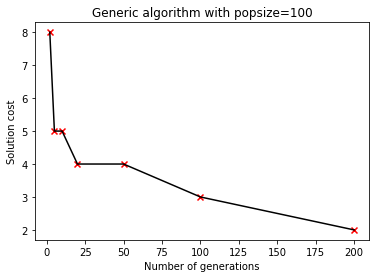

In [130]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter([2,5,10,20,50,100,200], [8,5,5,4,4,3,2],
            c="red", marker="x")

plt.plot([2,5,10,20,50,100,200], [8,5,5,4,4,3,2], c="black")

plt.title("Generic algorithm with popsize=100")
plt.xlabel("Number of generations")
plt.ylabel("Solution cost")


Text(0, 0.5, 'Solution cost')

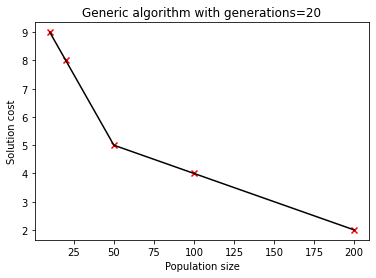

In [161]:
plt.scatter([10,20,50,100,200], [9,8,5,4,2],
            c="red", marker="x")

plt.plot([10,20,50,100,200], [9,8,5,4,2], c="black")

plt.title("Generic algorithm with generations=20")
plt.xlabel("Population size")
plt.ylabel("Solution cost")

<div style="background-color:yellow;">    
    <h3>Task 4 [Bonus]. Best solution</h3>
The sample input for this problem is very small. The total number of possible solutions is just 10!=3,628,800. Enumerate all possible solutions and find the one with the lowest cost. Was any of the optimization algorithms was able to find the best solution?  
</div> 

In [162]:
from itertools import product 

ls = []
sol = []
cost = 30
for i in product(range(10),range(9),range(8),range(7),range(6),range(5),range(4),range(3),range(2),range(1)):
    ls = list(i)
    if dorm_cost(ls) < cost:
        cost = dorm_cost(ls)
        sol = ls

print("The best cost is", cost)
print("The best housing assignment is:")
print_solution(sol)

The best cost is 2
The best housing assignment is:
    Daniel       Hill      ('Carriage', 'Hill')
    Steven   Dolliver      ('Dolliver', 'MODs')
    Akarsh     Crosby    ('Crosby', 'Dolliver')
    Kelvin   Dolliver      ('Dolliver', 'MODs')
     Betty     Crosby    ('Crosby', 'Carriage')
      Jeff       MODs          ('Hill', 'MODs')
       Cat       MODs        ('MODs', 'Crosby')
   Michael   Carriage      ('Carriage', 'Hill')
      Gary   Carriage      ('Carriage', 'Hill')
     James       Hill        ('Hill', 'Crosby')


The lowest cost for dorm assignment is 2, which is the best solution possible. This can only be attained by generic algorithms with generations >= 200 when popsize = 100 or with popsize >= 200 when generations = 20.

Examples are adopted from the book ''Programming Collective Intelligence'', by Toby Segaran, 2007.